# DSA - Deep Learning [4] - Reinforcement learning

In [1]:
# Install necessary libraries
!pip install flappy-bird-gymnasium pygame
!apt-get install -y xvfb python3-opengl ffmpeg
!pip install pyvirtualdisplay
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 60.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  freeglut3 libfontenc1 libglu1-mesa libxfont2 libxkbfile1 x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common
Suggested packages:
  libgle3 python3-numpy
The following NEW packages will be installed:
  freeglut3 libfontenc1 libglu1-mesa libxfont2 libxkbfile1 python3-opengl x11-xkb-utils xfonts-base
  xfonts-encodings xfonts-utils xserver-common xvfb
0 upgraded, 12 newly installed, 0 to remove and 49 not upgraded.
Need to get 8,639 kB of archives.
After this operation, 20.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 freeglut3 amd64 2.8.1-6

In [2]:
# Import necessary libraries
import os
import torch
import random
import numpy as np
import pygame
import imageio
from IPython.display import display, Image
from PIL import Image as PILImage  # Importing PIL for image manipulation
from flappy_bird_gymnasium.envs.flappy_bird_env import FlappyBirdEnv

# Set environment variables for rendering and audio in Colab
os.environ["SDL_VIDEODRIVER"] = "dummy"
os.environ["SDL_AUDIODRIVER"] = "dummy"


pygame 2.6.1 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
class CustomFlappyBirdEnv(FlappyBirdEnv):
    def __init__(self):
        super().__init__()

        # Initialize pygame and enforce dummy display
        pygame.init()
        if not pygame.display.get_init():
            pygame.display.init()
        pygame.display.set_mode((1, 1))  # Enforce dummy video mode

        # Initialize pygame mixer for audio
        if not pygame.mixer.get_init():
            pygame.mixer.init()

        # Initialize game surface
        self._surface = pygame.Surface((288, 512))  # Game surface dimensions

        # Initialize display surface (required for FlappyBirdEnv rendering)
        self._display = pygame.display.set_mode((288, 512))  # Create display window of appropriate size

        # Initialize the FPS clock for controlling the frame rate
        self._fps_clock = pygame.time.Clock()  # Initialize the FPS clock

        # Initialize image assets
        self._images = {}

        # Load images required for the game
        self._images["background"] = self._load_image("background-day.png")
        self._images["pipe"] = [
            self._load_image("pipe-green.png"),  # Top pipe
            pygame.transform.flip(self._load_image("pipe-green.png"), False, True)  # Bottom pipe (flipped)
        ]
        self._images["base"] = self._load_image("base.png")
        self._images["player"] = [
            self._load_image("yellowbird-upflap.png"),
            self._load_image("yellowbird-midflap.png"),
            self._load_image("yellowbird-downflap.png"),
        ]
        self._images["numbers"] = {
            i: self._load_image(f"{i}.png") for i in range(10)  # Load images for digits 0-9
        }

        # Load audio assets if needed
        self._audio = {
            "wing": self._load_audio("wing.wav"),
            "point": self._load_audio("point.wav"),
            "hit": self._load_audio("hit.wav"),
            "die": self._load_audio("die.wav"),
        }

        # Additional attributes required by the parent class
        self._score = 0
        self._player_index = 0
        self._base_shift = self._images["base"].get_width() - self._surface.get_width()
        self._pipes = []
        self._player_y = 256
        self._player_velocity_y = 0
        self._gravity = 1
        self._pipe_gap = 100

    def _load_image(self, filename):
        """
        Load an image from the assets directory.
        Args:
            filename: Name of the image file.
        Returns:
            Loaded pygame image.
        """
        assets_path = "/usr/local/lib/python3.10/dist-packages/flappy_bird_gymnasium/assets/sprites"
        filepath = os.path.join(assets_path, filename)
        return pygame.image.load(filepath).convert_alpha()

    def _load_audio(self, filename):
        """
        Load an audio file from the assets directory.
        Args:
            filename: Name of the audio file.
        Returns:
            Loaded pygame audio sound.
        """
        assets_path = "/usr/local/lib/python3.10/dist-packages/flappy_bird_gymnasium/assets/audio"
        filepath = os.path.join(assets_path, filename)
        return pygame.mixer.Sound(filepath)

    def render(self):
        """
        Render the game screen to the display and capture the frame for Colab visualization.
        """
        super().render()  # Call the parent class's render method

        # Capture the screen as an array
        frame = pygame.surfarray.array3d(pygame.display.get_surface())
        self.frames.append(frame)  # Save the frame for GIF creation

        # Control frame rate
        self._fps_clock.tick(self.metadata["render_fps"])

    def create_gif(self, gif_name="flappy_bird_game.gif"):
        """
        Create and display a GIF from the captured frames.
        """
        flipped_frames = []
        for frame in self.frames:
            pil_frame = PILImage.fromarray(frame)
            flipped_frame = pil_frame.rotate(270, expand=True)  # Rotate 270 degrees
            flipped_frames.append(flipped_frame)

        # Save and display the GIF
        flipped_gif_name = gif_name.replace(".gif", "_flipped.gif")
        imageio.mimsave(flipped_gif_name, flipped_frames, duration=1 / self.metadata["render_fps"])
        display(Image(flipped_gif_name))

    def reset(self):
        """
        Reset the environment and clear the stored frames.
        """
        self.frames = []  # Clear captured frames
        return super().reset()


In [4]:
class DQN(torch.nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = torch.nn.Linear(state_size, 128)
        self.fc2 = torch.nn.Linear(128, 128)
        self.fc3 = torch.nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [5]:
def preprocess_state(state):
    """
    Preprocess the state for the DQN model.
    Args:
        state: The raw state from the environment, which could be a tuple or array.
    Returns:
        A flattened and normalized 1D array representing the observation.
    """
    if isinstance(state, tuple):
        # If state is a tuple, take the first element (assuming it’s the observation)
        observation = state[0]
    else:
        observation = state

    # Ensure the observation is a NumPy array
    observation = np.array(observation, dtype=np.float32)

    # Normalize pixel values if it's an image or large array
    if observation.max() > 1.0:
        observation = observation / 255.0  # Normalize to range [0, 1]

    return observation.flatten()  # Flatten to a 1D array


In [6]:
def train_dqn(env, num_episodes, model_save_path="flappy_bird_dqn_final.pth", checkpoint_interval=100):
    """
    Train the DQN model on the environment.
    Args:
        env: The Flappy Bird environment.
        num_episodes: Number of training episodes.
        model_save_path: File path to save the final trained model.
        checkpoint_interval: Number of episodes between saving model checkpoints.
    Returns:
        Trained model.
    """
    # Determine state and action sizes dynamically
    state = preprocess_state(env.reset())
    state_size = state.shape[0]
    action_size = env.action_space.n

    # Initialize the DQN model
    model = DQN(state_size, action_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = torch.nn.MSELoss()

    # Replay buffer for storing experiences
    replay_buffer = []
    max_buffer_size = 1000

    # Hyperparameters
    gamma = 0.99  # Discount factor
    epsilon = 1.0  # Initial exploration rate
    epsilon_min = 0.01  # Minimum exploration rate
    epsilon_decay = 0.995  # Decay factor for exploration rate

    # Metrics
    rewards_per_episode = []  # Track rewards per episode
    steps_per_episode = []  # Track steps per episode

    for episode in range(num_episodes):
        state = preprocess_state(env.reset())  # Preprocess the initial state
        done = False
        total_reward = 0
        steps = 0

        while not done:
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state).unsqueeze(0)

            # Select an action (epsilon-greedy policy)
            if random.random() < epsilon:  # Explore
                action = random.choice(range(action_size))
            else:  # Exploit the learned policy
                with torch.no_grad():
                    action = torch.argmax(model(state_tensor)).item()

            # Perform the action in the environment
            next_state, reward, done, _, _ = env.step(action)
            next_state = preprocess_state(next_state)  # Preprocess the next state
            total_reward += reward
            steps += 1

            # Store the experience in the replay buffer
            replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) > max_buffer_size:
                replay_buffer.pop(0)  # Remove the oldest experience

            # Sample a random batch from the replay buffer for training
            if len(replay_buffer) >= 32:
                batch = random.sample(replay_buffer, 32)
                states, actions, rewards, next_states, dones = zip(*batch)

                # Convert batch to tensors
                states_tensor = torch.FloatTensor(states)
                actions_tensor = torch.LongTensor(actions).unsqueeze(1)
                rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1)
                next_states_tensor = torch.FloatTensor(next_states)
                dones_tensor = torch.FloatTensor(dones).unsqueeze(1)

                # Compute Q values for the current states
                q_values = model(states_tensor).gather(1, actions_tensor)

                # Compute target Q values
                with torch.no_grad():
                    next_q_values = model(next_states_tensor).max(1, keepdim=True)[0]
                    targets = rewards_tensor + gamma * next_q_values * (1 - dones_tensor)

                # Compute loss
                loss = loss_fn(q_values, targets)

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Move to the next state
            state = next_state

        # Decay exploration rate
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        # Track metrics
        rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps)

        # Print metrics for the current episode
        print(
            f"Episode {episode + 1}/{num_episodes}: "
            f"Total Reward = {total_reward:.2f}, "
            f"Steps = {steps}, "
            f"Epsilon = {epsilon:.4f}"
        )

        # Save model checkpoint every `checkpoint_interval` episodes
        if (episode + 1) % checkpoint_interval == 0:
            checkpoint_path = model_save_path.replace(".pth", f"_ep{episode + 1}.pth")
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Checkpoint saved at episode {episode + 1}: {checkpoint_path}")

    # Save the final trained model
    torch.save(model.state_dict(), model_save_path)
    print(f"Final model saved to {model_save_path}")

    # Print overall metrics
    print(f"Training completed. Average Reward: {np.mean(rewards_per_episode):.2f}, Average Steps: {np.mean(steps_per_episode):.2f}")

    return model, rewards_per_episode, steps_per_episode


In [7]:
def load_model(env, model_path="flappy_bird_dqn_final.pth"):
    """
    Load the trained RL model.
    Args:
        env: The Flappy Bird environment.
        model_path: Path to the saved model file.
    Returns:
        Loaded model.
    """
    # Preprocess the initial state to determine its size
    state = preprocess_state(env.reset())
    state_size = state.shape[0]
    action_size = env.action_space.n

    # Initialize the DQN model with the correct dimensions
    model = DQN(state_size, action_size)
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set the model to evaluation mode
    return model


In [8]:
def test_rl_agent_playing(env, model, step_limit=500):
    """
    Test the RL agent playing the game and generate a flipped GIF of the gameplay.
    Args:
        env: The Flappy Bird environment instance.
        model: The trained RL model.
        step_limit: Maximum number of steps to run the environment.
    """
    state = preprocess_state(env.reset())  # Preprocess the initial state
    for step in range(step_limit):
        # Debugging: Print state shape
        print(f"Step {step}: State shape: {state.shape}, State type: {type(state)}")

        # Convert state to tensor
        state_tensor = torch.FloatTensor(state).unsqueeze(0)

        # Select action based on the trained model
        with torch.no_grad():
            action = torch.argmax(model(state_tensor)).item()

        # Take the action in the environment
        next_state, reward, done, _, _ = env.step(action)
        next_state = preprocess_state(next_state)  # Preprocess the next state
        print(f"Step {step + 1}: Reward: {reward}, Done: {done}")

        # Render the frame for visualization
        env.render()

        if done:
            break

        # Update state for the next step
        state = next_state

    # Create and display the GIF after the game is over
    env.create_gif("flappy_bird_rl_agent.gif")


In [9]:
# Initialize the environment
env = CustomFlappyBirdEnv()

In [10]:
# Train the model
model = train_dqn(env, num_episodes=5000, model_save_path="flappy_bird_dqn_final.pth", checkpoint_interval=1000)

<ipython-input-6-783f1949abdc>:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states_tensor = torch.FloatTensor(states)


Streaming output truncated to the last 5000 lines.
Episode 8/5000: Total Reward = -6.90, Steps = 50, Epsilon = 0.9607
Episode 9/5000: Total Reward = -8.70, Steps = 50, Epsilon = 0.9559
Episode 10/5000: Total Reward = -8.70, Steps = 50, Epsilon = 0.9511
Episode 11/5000: Total Reward = -6.30, Steps = 50, Epsilon = 0.9464
Episode 12/5000: Total Reward = -8.70, Steps = 50, Epsilon = 0.9416
Episode 13/5000: Total Reward = -7.50, Steps = 50, Epsilon = 0.9369
Episode 14/5000: Total Reward = -8.10, Steps = 50, Epsilon = 0.9322
Episode 15/5000: Total Reward = -5.10, Steps = 50, Epsilon = 0.9276
Episode 16/5000: Total Reward = -8.10, Steps = 50, Epsilon = 0.9229
Episode 17/5000: Total Reward = -8.10, Steps = 50, Epsilon = 0.9183
Episode 18/5000: Total Reward = -8.10, Steps = 50, Epsilon = 0.9137
Episode 19/5000: Total Reward = -6.90, Steps = 50, Epsilon = 0.9092
Episode 20/5000: Total Reward = -6.90, Steps = 50, Epsilon = 0.9046
Episode 21/5000: Total Reward = -7.50, Steps = 50, Epsilon = 0.9001

<ipython-input-7-b18a0f46fe67>:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Step 0: State shape: (180,), State type: <class 'numpy.ndarray'>
Step 1: Reward: 0.1, Done: False
Step 1: State shape: (180,), State type: <class 'numpy.ndarray'>
Step 2: Reward: 0.1, Done: False
Step 2: State shape: (180,), State type: <class 'numpy.ndarray'>
Step 3: Reward: 0.1, Done: False
Step 3: State shape: (180,), State type: <class 'numpy.ndarray'>
Step 4: Reward: 0.1, Done: False
Step 4: State shape: (180,), State type: <class 'numpy.ndarray'>
Step 5: Reward: 0.1, Done: False
Step 5: State shape: (180,), State type: <class 'numpy.ndarray'>
Step 6: Reward: 0.1, Done: False
Step 6: State shape: (180,), State type: <class 'numpy.ndarray'>
Step 7: Reward: 0.1, Done: False
Step 7: State shape: (180,), State type: <class 'numpy.ndarray'>
Step 8: Reward: 0.1, Done: False
Step 8: State shape: (180,), State type: <class 'numpy.ndarray'>
Step 9: Reward: 0.1, Done: False
Step 9: State shape: (180,), State type: <class 'numpy.ndarray'>
Step 10: Reward: 0.1, Done: False
Step 10: State shap

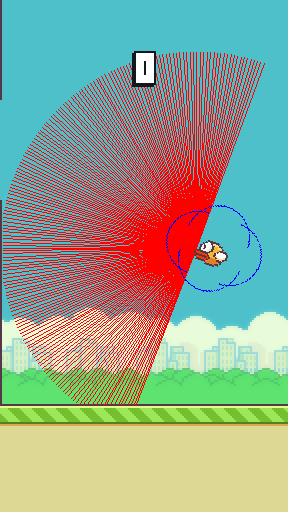

In [12]:
# Load the trained model
model = load_model(env, "flappy_bird_dqn_final_ep4000.pth")

# Test the RL agent and create a flipped GIF
test_rl_agent_playing(env, model)